# 1-Data

In [1]:
!pip install yfinance ta numpy matplotlib seaborn pandas scikit-learn keras prophet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# Import the necessary libraries. Each library serves a different purpose:
# - yfinance: Used to fetch financial data from Yahoo Finance.
# - ta: Technical Analysis library to calculate various indicators.
# - numpy: Library for numerical operations.
# - matplotlib: Plotting library for data visualization.
# - seaborn: Statistical data visualization based on matplotlib.
# - pandas: Data manipulation and analysis library.
# - scikit-learn: Machine learning library for predictive data analysis.
# - keras: Deep learning library for neural networks.
# - prophet: Forecasting tool by Facebook for time series dataimport yfinance as yf
import yfinance as yf
import ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [3]:
def get_stock_data(ticker_symbol, start_date, end_date):
    """
    Belirtilen hisse senedi sembolü için tarih aralığında veri çeker.
    
    Parametreler:
    - ticker_symbol (str): Hisse senedi sembolü (örn: "AAPL")
    - start_date (str): Başlangıç tarihi (YYYY-MM-DD)
    - end_date (str): Bitiş tarihi (YYYY-MM-DD)
    
    Dönüş:
    - pandas.DataFrame: Hisse senedi verileri
    """
    ticker = yf.Ticker(ticker_symbol)
    data = ticker.history(start=start_date, end=end_date)
    data.info()
    return data

# Kullanım örneği
df = get_stock_data("AAPL", "2024-01-01", "2024-10-10")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2024-01-02 00:00:00-05:00 to 2024-10-09 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          195 non-null    float64
 1   High          195 non-null    float64
 2   Low           195 non-null    float64
 3   Close         195 non-null    float64
 4   Volume        195 non-null    int64  
 5   Dividends     195 non-null    float64
 6   Stock Splits  195 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 12.2 KB


In [4]:
def summarize_data(df, head_rows=5):
    """
    DataFrame için özet istatistikleri ve ilk birkaç satırı döndürür.

    Parametreler:
    - df (pandas.DataFrame): Analiz edilecek veri seti
    - head_rows (int, opsiyonel): Kaç satır gösterileceği (varsayılan: 5)

    Dönüş:
    - tuple: (Özet istatistikler, İlk birkaç satır)
    """
    summary = df.describe().T
    head_data = df.head(head_rows)
    return summary, head_data

# Kullanım örneği
summary, head_data = summarize_data(df)
print(summary)
head_data

              count          mean           std           min           25%  \
Open          195.0  1.978821e+02  2.191650e+01  1.647539e+02  1.811187e+02   
High          195.0  1.997772e+02  2.217487e+01  1.658001e+02  1.821492e+02   
Low           195.0  1.960600e+02  2.146802e+01  1.634884e+02  1.793860e+02   
Close         195.0  1.980028e+02  2.192427e+01  1.644051e+02  1.809643e+02   
Volume        195.0  6.086247e+07  3.278727e+07  3.029900e+07  4.424775e+07   
Dividends     195.0  3.794872e-03  3.044276e-02  0.000000e+00  0.000000e+00   
Stock Splits  195.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                       50%           75%           max  
Open          1.910739e+02  2.210457e+02  2.359470e+02  
High          1.922956e+02  2.230746e+02  2.366953e+02  
Low           1.898412e+02  2.180934e+02  2.325646e+02  
Close         1.908589e+02  2.208470e+02  2.342908e+02  
Volume        5.299080e+07  6.612390e+07  3.186799e+08  
Dividends     0.000000e+0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,186.237603,187.521323,182.993502,184.734970,82488700,0.0,0.0
2024-01-03 00:00:00-05:00,183.321908,184.973819,182.535751,183.351761,58414500,0.0,0.0
2024-01-04 00:00:00-05:00,181.261983,182.197403,179.998185,181.023163,71983600,0.0,0.0
2024-01-05 00:00:00-05:00,181.102771,181.869006,179.291637,180.296707,62303300,0.0,0.0
2024-01-08 00:00:00-05:00,181.202281,184.695178,180.615161,184.655365,59144500,0.0,0.0


# 2-Feature Engineering

In [5]:
def add_technical_indicators(df):
    """
    DataFrame'e çeşitli teknik göstergeleri ekler.

    Parametreler:
    - df (pandas.DataFrame): Hisse senedi verileri içeren DataFrame

    Dönüş:
    - pandas.DataFrame: Teknik göstergeler eklenmiş DataFrame
    """
    # Hareketli Ortalamalar
    df["SMA_20"] = ta.trend.sma_indicator(df["Close"], window=20)

    # RSI (Göreceli Güç Endeksi)
    df["RSI_14"] = ta.momentum.rsi(df["Close"], window=14)

    # MACD (Hareketli Ortalama Yakınsama Iraksama)
    macd = ta.trend.MACD(df["Close"])
    df["MACD"] = macd.macd()
    df["MACD_Signal"] = macd.macd_signal()

    # Bollinger Bantları
    bollinger = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
    df["Bollinger_High"] = bollinger.bollinger_hband()
    df["Bollinger_Low"] = bollinger.bollinger_lband()
    
    # ATR (Ortalama Gerçek Aralık)
    df["ATR_14"] = ta.volatility.average_true_range(df["High"], df["Low"], df["Close"], window=14)

    # Logaritmik Getiri
    df["Log_Returns"] = np.log(df["Close"] / df["Close"].shift(1))

    # 20 Günlük Hareketli Volatilite
    df["Rolling_Volatility_20"] = df["Close"].rolling(window=20).std()

    # Kümülatif Getiri
    df["Cumulative_Returns"] = (df["Close"] / df["Close"].iloc[0]) - 1

    # Fiyatın SMA'ya Olan Mesafesi
    df["Price_Distance_SMA"] = df["Close"] - df["SMA_20"]

    # Bollinger %B
    df["Bollinger_%B"] = (df["Close"] - df["Bollinger_Low"]) / (df["Bollinger_High"] - df["Bollinger_Low"])

    return df

# Kullanım örneği
df = add_technical_indicators(df)




In [6]:
def prepare_features_and_target(df):
    """
    Model eğitimi için bağımsız (X) ve bağımlı (y) değişkenleri seçer ve X'in özet istatistiklerini döndürür.

    Parametreler:
    - df (pandas.DataFrame): Teknik göstergeler içeren hisse senedi verisi

    Dönüş:
    - tuple: (Bağımsız değişkenler (X), Bağımlı değişken (y), X'in özet istatistikleri)
    """
    feature_columns = ["SMA_20", "RSI_14", "MACD", "MACD_Signal", "Bollinger_High", "Bollinger_Low",
                       "ATR_14", "Log_Returns", "Rolling_Volatility_20", "Cumulative_Returns",
                       "Price_Distance_SMA", "Bollinger_%B"]
    
    X = df[feature_columns]
    y = df["Close"]

    return X, y, X.describe().T

# Kullanım örneği
X, y, X_summary = prepare_features_and_target(df)
print(X_summary)

                       count        mean        std         min         25%  \
SMA_20                 176.0  197.180949  21.140199  168.762851  176.669743   
RSI_14                 182.0   54.009166  13.058620   21.755598   42.797058   
MACD                   170.0    1.544812   3.488174   -4.183602   -1.280503   
MACD_Signal            162.0    1.589967   3.388579   -3.517289   -1.390608   
Bollinger_High         176.0  207.506871  22.855633  174.122900  189.355934   
Bollinger_Low          176.0  186.855027  20.184301  158.900487  166.364440   
ATR_14                 195.0    3.864046   1.402994    0.000000    3.228425   
Log_Returns            194.0    0.001114   0.015037   -0.049366   -0.007036   
Rolling_Volatility_20  176.0    5.297086   2.175520    2.422895    3.561414   
Cumulative_Returns     195.0    0.071821   0.118680   -0.110049   -0.020411   
Price_Distance_SMA     176.0    2.013238   7.273227  -15.459084   -3.412396   
Bollinger_%B           176.0    0.541129   0.325729 

In [7]:
def display_info(df):
    """
    DataFrame'in bilgilerini (dtype, eksik değerler, bellek kullanımı vb.) ekrana yazdırır.

    Parametreler:
    - df (pandas.DataFrame): Bilgisi gösterilecek veri seti

    Dönüş:
    - None (Sadece çıktıyı yazdırır)
    """
    df.info()

# Kullanım örneği
display_info(X)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2024-01-02 00:00:00-05:00 to 2024-10-09 00:00:00-04:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SMA_20                 176 non-null    float64
 1   RSI_14                 182 non-null    float64
 2   MACD                   170 non-null    float64
 3   MACD_Signal            162 non-null    float64
 4   Bollinger_High         176 non-null    float64
 5   Bollinger_Low          176 non-null    float64
 6   ATR_14                 195 non-null    float64
 7   Log_Returns            194 non-null    float64
 8   Rolling_Volatility_20  176 non-null    float64
 9   Cumulative_Returns     195 non-null    float64
 10  Price_Distance_SMA     176 non-null    float64
 11  Bollinger_%B           176 non-null    float64
dtypes: float64(12)
memory usage: 19.8 KB


In [8]:
def fill_missing_values_and_display_info(df):
    """
    DataFrame'deki eksik değerleri, her sütunun medyan değeriyle doldurur ve ardından DataFrame'in bilgilerini gösterir.

    Parametreler:
    - df (pandas.DataFrame): Eksik değerleri doldurulacak veri seti

    Dönüş:
    - pandas.DataFrame: Eksik değerleri doldurulmuş ve bilgileri gösterilmiş DataFrame
    """
    # Eksik değerleri medyan ile doldur
    df = df.apply(lambda col: col.fillna(col.median()), axis=0)
    
    # DataFrame'in bilgilerini yazdır
    df.info()

    return df

# Kullanım örneği
X = fill_missing_values_and_display_info(X)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2024-01-02 00:00:00-05:00 to 2024-10-09 00:00:00-04:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SMA_20                 195 non-null    float64
 1   RSI_14                 195 non-null    float64
 2   MACD                   195 non-null    float64
 3   MACD_Signal            195 non-null    float64
 4   Bollinger_High         195 non-null    float64
 5   Bollinger_Low          195 non-null    float64
 6   ATR_14                 195 non-null    float64
 7   Log_Returns            195 non-null    float64
 8   Rolling_Volatility_20  195 non-null    float64
 9   Cumulative_Returns     195 non-null    float64
 10  Price_Distance_SMA     195 non-null    float64
 11  Bollinger_%B           195 non-null    float64
dtypes: float64(12)
memory usage: 19.8 KB


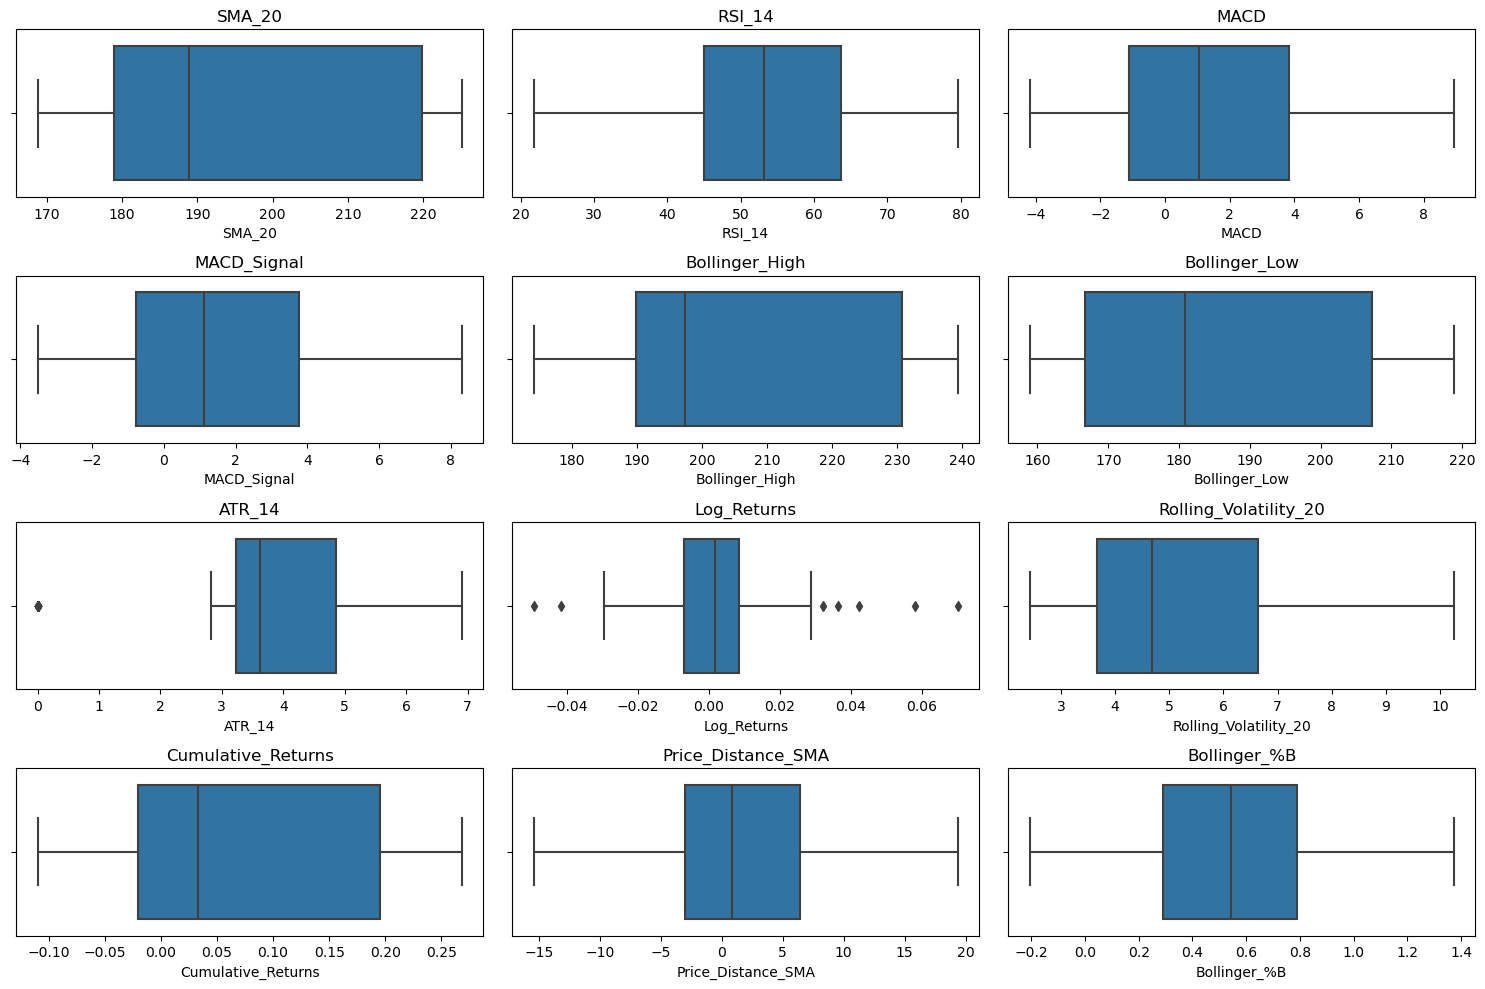

In [9]:
def plot_boxplots(df):
    """
    DataFrame'deki her sütun için kutu grafiği (boxplot) çizer ve başlıkları düzenler.
    
    Parametreler:
    - df (pandas.DataFrame): Grafik oluşturulacak veri seti
    """
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

# Kullanım örneği
plot_boxplots(X)




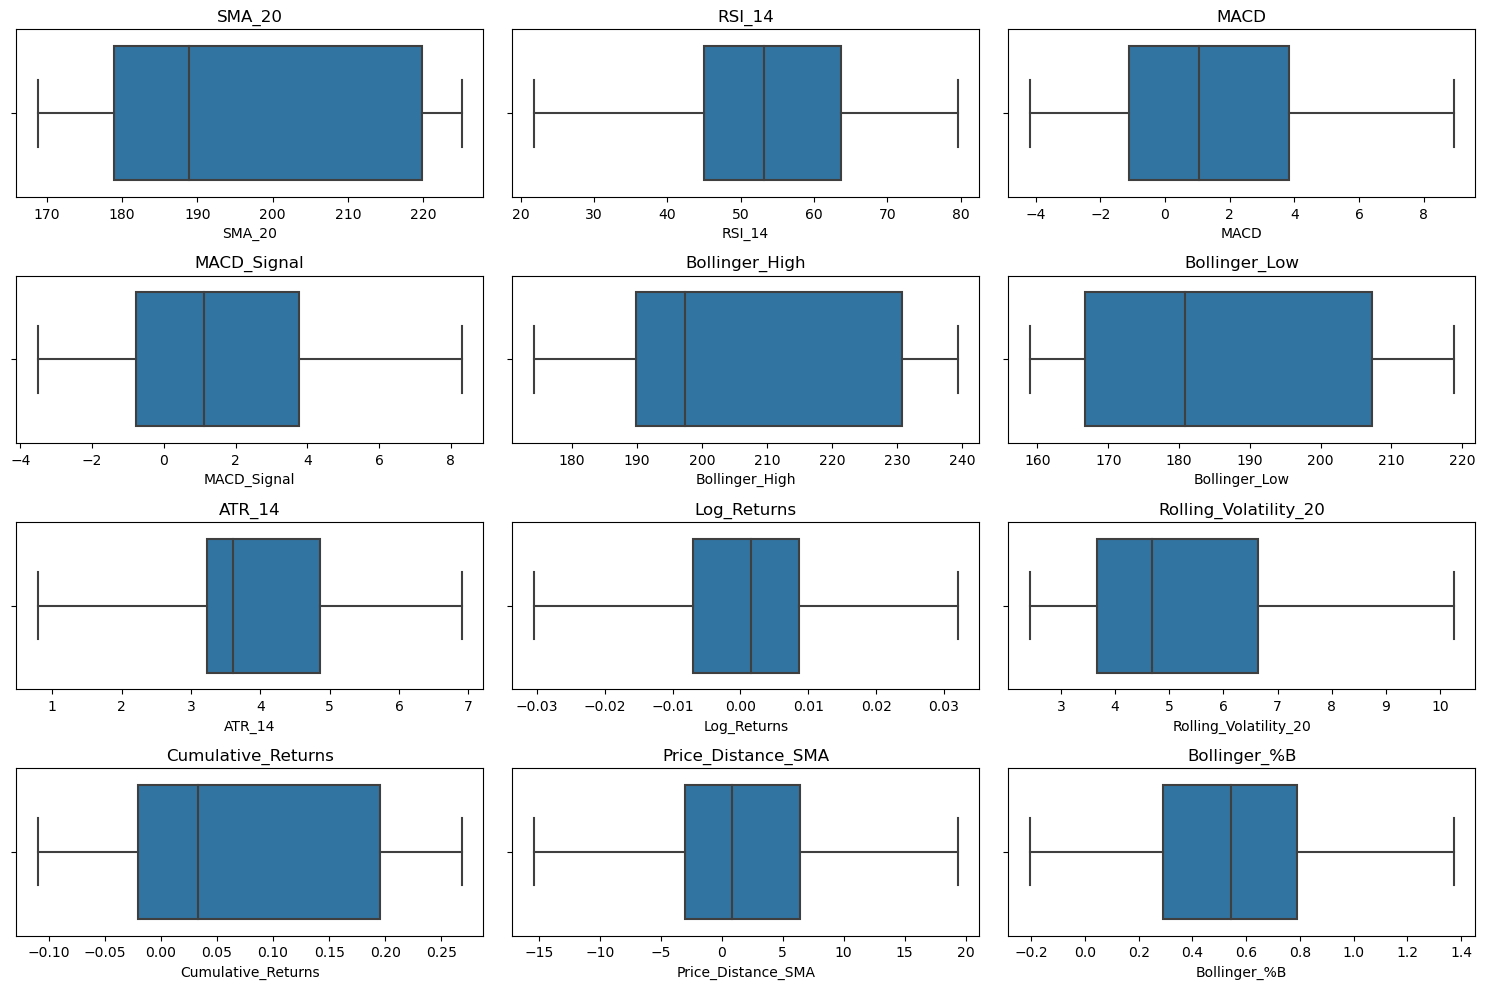

In [10]:
def suppress_outliers(col):
    """
    Bir sütundaki aykırı değerleri bastırır (IQR yöntemiyle).

    Parametreler:
    - col (pandas.Series): Aykırı değerlerin bastırılacağı sütun

    Dönüş:
    - pandas.Series: Aykırı değerleri bastırılmış sütun
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return col.clip(lower_bound, upper_bound)

def detect_and_suppress_outliers(df):
    """
    DataFrame'deki her sütunda aykırı değerleri tespit eder ve yalnızca aykırı değer bulunan sütunları bastırır.
    
    Parametreler:
    - df (pandas.DataFrame): Veri seti
    
    Dönüş:
    - pandas.DataFrame: Aykırı değerleri bastırılmış DataFrame
    """
    # Aykırı değer tespiti ve bastırma işlemi
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Eğer aykırı değer varsa, bu sütunda bastırma işlemi yap
        if df[col].lt(lower_bound).any() or df[col].gt(upper_bound).any():
            df[col] = suppress_outliers(df[col])
    
    return df

def plot_boxplots_with_suppressed_outliers(df):
    """
    DataFrame'deki sadece aykırı değerleri bastırılmış sütunlar için kutu grafiği çizer.
    
    Parametreler:
    - df (pandas.DataFrame): Grafik oluşturulacak veri seti
    """
    # Aykırı değer tespiti ve bastırma işlemi
    df = detect_and_suppress_outliers(df)
    
    # Kutu grafiği çizme
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        if df[col].dtype in ['float64', 'int64']:  # Sadece sayısal sütunlar için
            sns.boxplot(x=df[col], ax=axes[i])
            axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

# Kullanım örneği
plot_boxplots_with_suppressed_outliers(X)





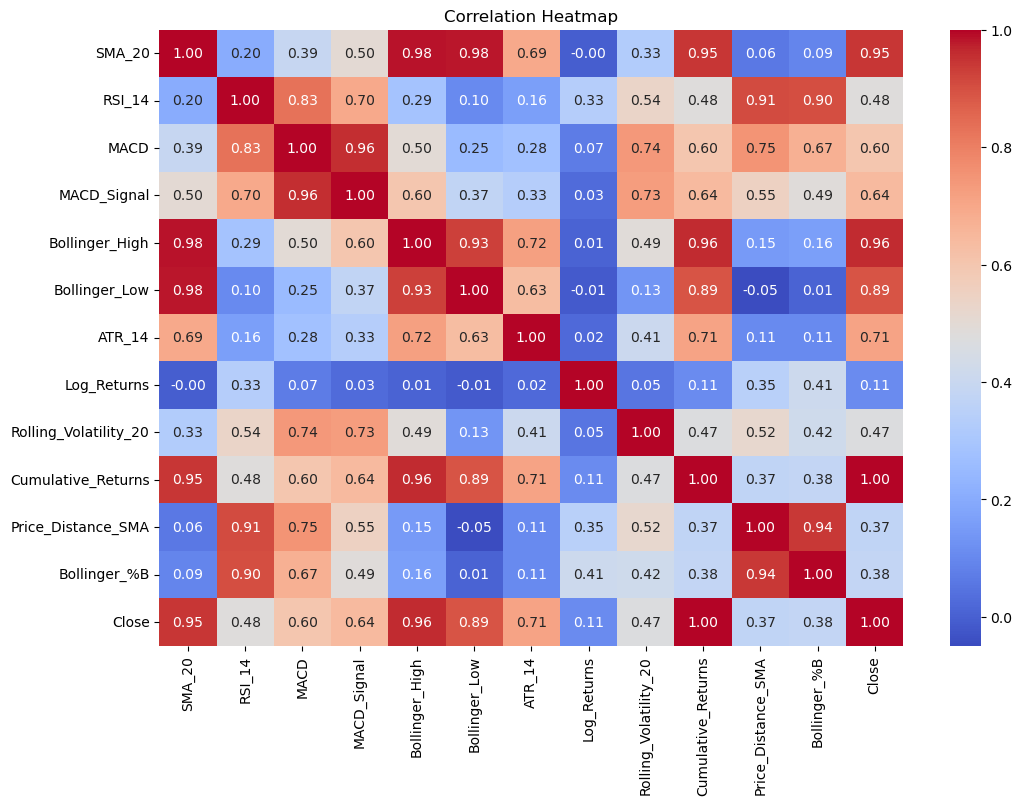

In [11]:
def plot_correlation_heatmap(X, y):
    """
    X ve y veri seti arasındaki korelasyonu hesaplar ve ısı haritası (heatmap) olarak görselleştirir.

    Parametreler:
    - X (pandas.DataFrame): Özelliklerin yer aldığı veri seti
    - y (pandas.Series): Hedef değişken (Close)
    """
    # Y hedef değişkenini X veri setine ekle
    df_combined = X.copy()
    df_combined["Close"] = y
    
    # Korelasyon matrisini hesapla
    correlation_matrix = df_combined.corr()
    
    # Isı haritası çizme
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

# Kullanım örneği
plot_correlation_heatmap(X, y)




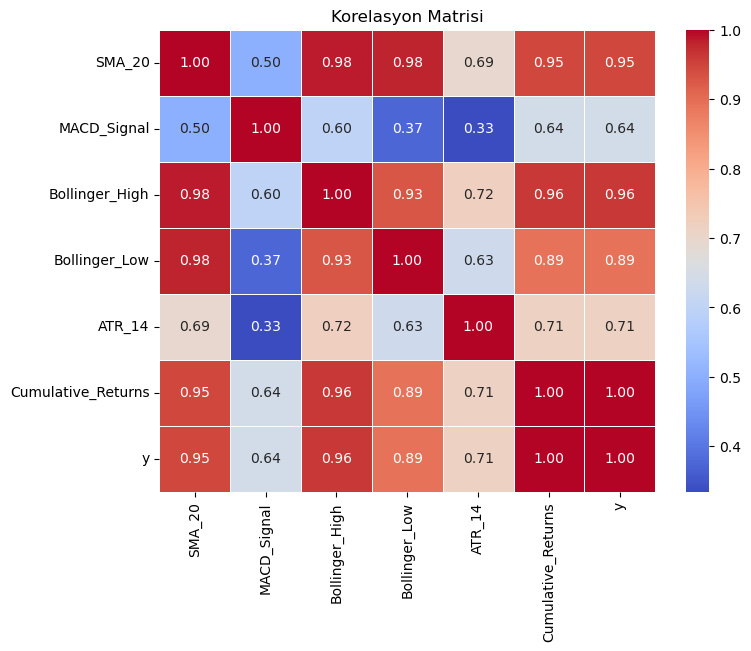

Seçilen Değişkenler: ['SMA_20', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low', 'ATR_14', 'Cumulative_Returns']


In [12]:
def select_and_plot_correlated_features(X, y, threshold=0.6):
    """
    Hedef değişken (y) ile korelasyonu belirtilen eşiğin üzerinde olan özellikleri seçer,
    yeni korelasyon matrisini oluşturur ve görselleştirir.
    
    Parametreler:
    - X (pandas.DataFrame): Özelliklerin yer aldığı veri seti
    - y (pandas.Series): Hedef değişken (Close)
    - threshold (float): Korelasyon eşiği. Varsayılan olarak 0.6
    
    Dönüş:
    - pandas.DataFrame: Seçilen özelliklerin yer aldığı yeni DataFrame
    """
    # Hedef değişken ile korelasyon hesapla
    correlations = X.corrwith(pd.Series(y))
    
    # Korelasyonu mutlak değeri eşiğin üzerinde olan özellikleri seç
    selected_features = correlations[correlations.abs() > threshold].index
    X_new = X[selected_features]
    
    # Yeni korelasyon matrisi oluştur
    corr_matrix = X_new.assign(y=y).corr()
    
    # Isı haritası çizme
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Korelasyon Matrisi")
    plt.show()
    
    # Seçilen değişkenleri yazdır
    print("Seçilen Değişkenler:", list(selected_features))
    return X_new

# Kullanım örneği
X_new = select_and_plot_correlated_features(X, y)


# 3-Model Development

Epoch 1/50


C:\Users\fassf\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3198
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2753 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2328 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2258 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1692 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1078 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0795 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0374 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

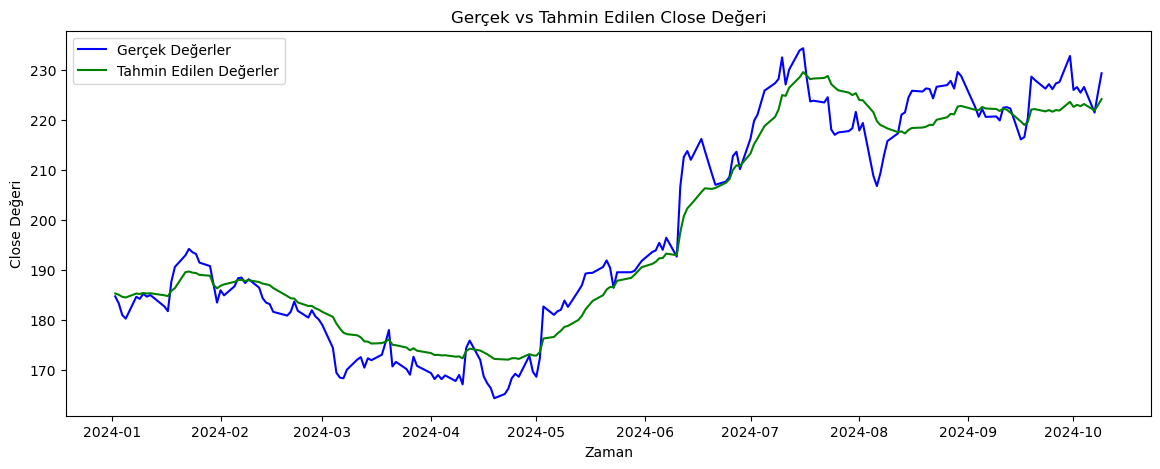

                         Date  Gerçek Değerler  Tahmin Değerleri
0   2024-01-02 00:00:00-05:00       184.734970        185.319183
1   2024-01-03 00:00:00-05:00       183.351761        185.069916
2   2024-01-04 00:00:00-05:00       181.023163        184.652023
3   2024-01-05 00:00:00-05:00       180.296707        184.522095
4   2024-01-08 00:00:00-05:00       184.655365        185.304825
..                        ...              ...               ...
190 2024-10-03 00:00:00-04:00       225.421982        222.727341
191 2024-10-04 00:00:00-04:00       226.550751        223.151550
192 2024-10-07 00:00:00-04:00       221.446365        221.866150
193 2024-10-08 00:00:00-04:00       225.521881        222.949493
194 2024-10-09 00:00:00-04:00       229.287735        224.135529

[195 rows x 3 columns]


In [13]:
def train_and_predict_lstm(X_new, df, epochs=50, batch_size=32):
    """
    LSTM modelini eğitir ve 'Close' değerlerini tahmin eder.
    
    Parametreler:
    - X_new (pandas.DataFrame): Özelliklerin yer aldığı veri seti (Close dışındaki sütunlar)
    - df (pandas.DataFrame): 'Close' sütununu içeren veri seti
    - epochs (int): Model eğitimi için epoch sayısı (varsayılan: 50)
    - batch_size (int): Model eğitimi için batch size (varsayılan: 32)
    
    Dönüş:
    - results (pandas.DataFrame): Gerçek ve tahmin edilen değerleri içeren DataFrame
    """
    # 'Close' sütunu hedef değişken
    y = df['Close'].values.reshape(-1, 1)

    # Veriyi ölçeklendirme
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X_new)
    y_scaled = scaler_y.fit_transform(y)

    # LSTM girişi için veriyi yeniden şekillendirme
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # LSTM modelinin oluşturulması
    model = Sequential()
    model.add(LSTM(units=30, return_sequences=True, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=30, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Modeli eğitme
    history = model.fit(X_scaled, y_scaled, epochs=epochs, batch_size=batch_size)

    # Tüm veri seti ile tahmin yapma
    y_pred_scaled = model.predict(X_scaled)

    # Ölçeklendirilmiş tahminleri geri ölçeklendirme
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_actual = scaler_y.inverse_transform(y_scaled)

    # Gerçek ve tahmin edilen değerleri bir DataFrame'de birleştirme
    results = pd.DataFrame({
        'Date': df.index,
        'Gerçek Değerler': y_actual.flatten(),
        'Tahmin Değerleri': y_pred.flatten()
    })

    # Sonuçları görselleştirme
    plt.figure(figsize=(14, 5))

    # Gerçek set
    plt.plot(df.index, y_actual, color='blue', label='Gerçek Değerler')

    # Tahmin set
    plt.plot(df.index, y_pred, color='green', label='Tahmin Edilen Değerler')

    plt.title('Gerçek vs Tahmin Edilen Close Değeri')
    plt.xlabel('Zaman')
    plt.ylabel('Close Değeri')
    plt.legend()
    plt.show()

    # Gerçek ve tahmin değerlerini gösterme
    print(results)
    
    return results

# Kullanım örneği
# df = pd.read_csv('your_dataset.csv') # Eğer dışarıdan veri yükleyecekseniz, burada df'yi yükleyin.
# X_new = df.drop(columns=['Close']) # Özelliklerin yer aldığı veri seti

results = train_and_predict_lstm(X_new, df)




19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
0   2024-01-02  184.665824  183.256473  186.067903
1   2024-01-03  184.815881  183.439049  186.225589
2   2024-01-04  184.985569  183.567275  186.362763
3   2024-01-05  185.191422  183.838960  186.616659
4   2024-01-08  185.338522  183.870568  186.754753
..         ...         ...         ...         ...
220 2024-11-04  225.359055  220.035819  230.611369
221 2024-11-05  225.502157  220.117821  231.036541
222 2024-11-06  225.609510  219.703859  231.441379
223 2024-11-07  225.736494  219.575445  232.076755
224 2024-11-08  225.899643  219.125975  232.535145

[225 rows x 4 columns]


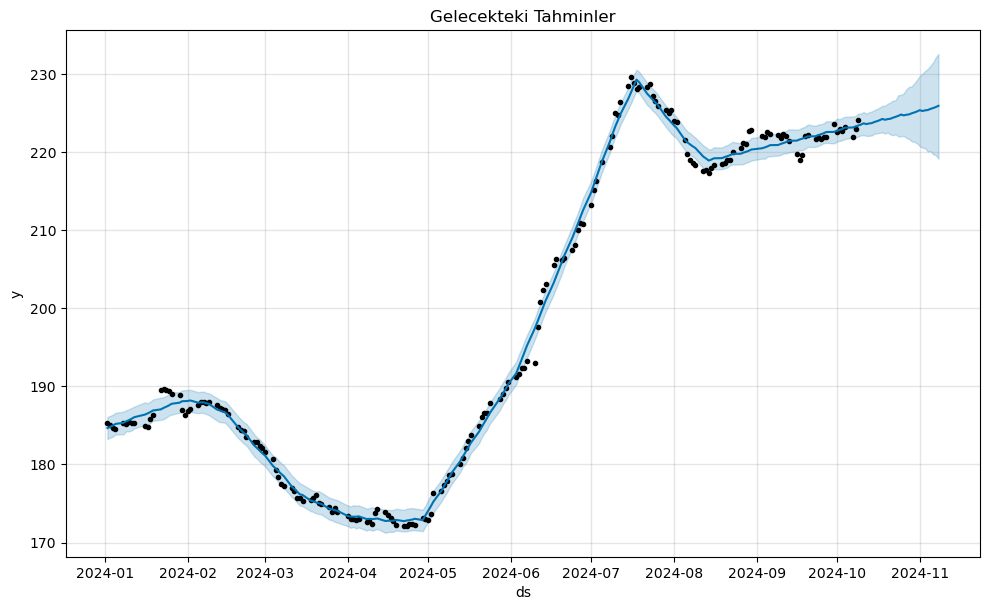

In [14]:
def forecast_with_prophet(results, periods=30):
    """
    Prophet modeli kullanarak geçmiş verilere dayalı gelecekteki tahminleri yapar ve görselleştirir.
    
    Parametreler:
    - results (pandas.DataFrame): Gerçek ve tahmin edilen 'Close' değerlerini içeren DataFrame
    - periods (int): Gelecekteki gün sayısı (varsayılan: 30)
    
    Dönüş:
    - forecast (pandas.DataFrame): Tahmin edilen değerler ile birlikte tarih ve güven aralıkları
    """
    # Copy the results DataFrame
    forec = results.copy()

    # Select the relevant columns and rename them for Prophet
    forec = forec[["Date", "Tahmin Değerleri"]]
    forec.rename(columns={"Date": "ds", "Tahmin Değerleri": "y"}, inplace=True)

    # Remove timezone information from the 'ds' column
    forec['ds'] = forec['ds'].dt.tz_localize(None)

    # Create and fit the Prophet model
    model = Prophet()
    model.fit(forec)

    # Create future dates for the next 'periods' days
    future = model.make_future_dataframe(periods=periods)

    # Make predictions
    forecast = model.predict(future)

    # Display the forecasted results
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Plot the forecast
    fig = model.plot(forecast)
    plt.title('Gelecekteki Tahminler')
    plt.show()

    return forecast

# Kullanım örneği
forecast = forecast_with_prophet(results)




# 4- Evaluation Metrics

In [15]:
def evaluate_time_series_metrics(results):
    """
    Zaman serisi değerlendirmesi yapmak için önemli metrikleri hesaplar.
    
    Parametreler:
    - results (pandas.DataFrame): Gerçek ve tahmin edilen değerleri içeren DataFrame.
    
    Dönüş:
    - metrics (dict): Modelin performansını ölçen metrikler (MAE, MSE, RMSE, R², AIC, BIC vb.)
    """
    # Gerçek ve tahmin edilen değerleri ayırma
    y_actual = results['Gerçek Değerler'].values
    y_pred = results['Tahmin Değerleri'].values

    # Ortalama Mutlak Hata (MAE)
    mae = mean_absolute_error(y_actual, y_pred)
    
    # Ortalama Kare Hata (MSE)
    mse = mean_squared_error(y_actual, y_pred)
    
    # Kök Ortalama Kare Hata (RMSE)
    rmse = np.sqrt(mse)
    
    # R-Kare (R^2) Skoru
    r2 = r2_score(y_actual, y_pred)

    # AIC (Akaike Information Criterion) için n ve k'yi hesaplama
    n = len(y_actual)  # Veri setindeki örnek sayısı
    k = 1  # Basit model varsayımı (sadece tahminler ile)
    residual_sum_of_squares = np.sum((y_actual - y_pred)**2)  # Kalan kareler toplamı
    aic = n * math.log(residual_sum_of_squares / n) + 2 * k

    # BIC (Bayesian Information Criterion)
    bic = n * math.log(residual_sum_of_squares / n) + k * math.log(n)

    # Sonuçları bir sözlük olarak döndürme
    metrics = {
        'MAE (Mean Absolute Error)': mae,
        'MSE (Mean Squared Error)': mse,
        'RMSE (Root Mean Squared Error)': rmse,
        'R2 (R-Squared)': r2,
        'AIC (Akaike Information Criterion)': aic,
        'BIC (Bayesian Information Criterion)': bic
    }

    # Metrikleri yazdırma
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')
    
    return metrics

# Kullanım örneği
metrics = evaluate_time_series_metrics(results)




MAE (Mean Absolute Error): 4.0004
MSE (Mean Squared Error): 23.5446
RMSE (Root Mean Squared Error): 4.8523
R2 (R-Squared): 0.9508
AIC (Akaike Information Criterion): 617.9845
BIC (Bayesian Information Criterion): 621.2575
